In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Root path to datasets
path_to_dataset = 'CICIDS2017/MachineLearningCVE'

# Paths to dataset files
dataset_paths = [
    f'{path_to_dataset}/Monday-WorkingHours.pcap_ISCX.csv',
    f'{path_to_dataset}/Tuesday-WorkingHours.pcap_ISCX.csv',
    f'{path_to_dataset}/Wednesday-workingHours.pcap_ISCX.csv',
    f'{path_to_dataset}/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    f'{path_to_dataset}/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    f'{path_to_dataset}/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    f'{path_to_dataset}/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    f'{path_to_dataset}/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
]

In [2]:
# Load the datasets
monday_data = pd.read_csv(f'{path_to_dataset}/Monday-WorkingHours.pcap_ISCX.csv')
tuesday_data = pd.read_csv(f'{path_to_dataset}/Tuesday-WorkingHours.pcap_ISCX.csv')
wednesday_data = pd.read_csv(f'{path_to_dataset}/Wednesday-workingHours.pcap_ISCX.csv')
thursday_morning_webattacks_data = pd.read_csv(f'{path_to_dataset}/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
thursday_afternoon_infiltration_data = pd.read_csv(f'{path_to_dataset}/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
friday_morning_data = pd.read_csv(f'{path_to_dataset}/Friday-WorkingHours-Morning.pcap_ISCX.csv')
friday_afternoon_portscan_data = pd.read_csv(f'{path_to_dataset}/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
friday_afternoon_ddos_data = pd.read_csv(f'{path_to_dataset}/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

# Create a summary of each dataset to understand the initial structure
datasets = {
    'Monday': monday_data,
    'Tuesday': tuesday_data,
    'Wednesday': wednesday_data,
    'Thursday Morning Web Attacks': thursday_morning_webattacks_data,
    'Thursday Afternoon Infiltration': thursday_afternoon_infiltration_data,
    'Friday Morning': friday_morning_data,
    'Friday Afternoon PortScan': friday_afternoon_portscan_data,
    'Friday Afternoon DDoS': friday_afternoon_ddos_data
}

# Generate summary information for each dataset
summary_info = {day: {'Shape': data.shape, 'Columns': data.columns.tolist()} for day, data in datasets.items()}

summary_info

{'Monday': {'Shape': (529918, 79),
  'Columns': [' Destination Port',
   ' Flow Duration',
   ' Total Fwd Packets',
   ' Total Backward Packets',
   'Total Length of Fwd Packets',
   ' Total Length of Bwd Packets',
   ' Fwd Packet Length Max',
   ' Fwd Packet Length Min',
   ' Fwd Packet Length Mean',
   ' Fwd Packet Length Std',
   'Bwd Packet Length Max',
   ' Bwd Packet Length Min',
   ' Bwd Packet Length Mean',
   ' Bwd Packet Length Std',
   'Flow Bytes/s',
   ' Flow Packets/s',
   ' Flow IAT Mean',
   ' Flow IAT Std',
   ' Flow IAT Max',
   ' Flow IAT Min',
   'Fwd IAT Total',
   ' Fwd IAT Mean',
   ' Fwd IAT Std',
   ' Fwd IAT Max',
   ' Fwd IAT Min',
   'Bwd IAT Total',
   ' Bwd IAT Mean',
   ' Bwd IAT Std',
   ' Bwd IAT Max',
   ' Bwd IAT Min',
   'Fwd PSH Flags',
   ' Bwd PSH Flags',
   ' Fwd URG Flags',
   ' Bwd URG Flags',
   ' Fwd Header Length',
   ' Bwd Header Length',
   'Fwd Packets/s',
   ' Bwd Packets/s',
   ' Min Packet Length',
   ' Max Packet Length',
   ' Packet 

In [13]:
print(monday_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529918 entries, 0 to 529917
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             529918 non-null  int64  
 1    Flow Duration                529918 non-null  int64  
 2    Total Fwd Packets            529918 non-null  int64  
 3    Total Backward Packets       529918 non-null  int64  
 4   Total Length of Fwd Packets   529918 non-null  int64  
 5    Total Length of Bwd Packets  529918 non-null  int64  
 6    Fwd Packet Length Max        529918 non-null  int64  
 7    Fwd Packet Length Min        529918 non-null  int64  
 8    Fwd Packet Length Mean       529918 non-null  float64
 9    Fwd Packet Length Std        529918 non-null  float64
 10  Bwd Packet Length Max         529918 non-null  int64  
 11   Bwd Packet Length Min        529918 non-null  int64  
 12   Bwd Packet Length Mean       529918 non-nul

In [15]:
from sklearn.preprocessing import LabelEncoder

# Trim leading and trailing spaces from column names
monday_data.columns = monday_data.columns.str.strip()

# Encode the 'Label' column
label_encoder = LabelEncoder()
monday_data['Label'] = label_encoder.fit_transform(monday_data['Label'])

# Handle the minor missing data in 'Flow Bytes/s'
# Option 1: Drop rows with missing 'Flow Bytes/s' values
# monday_data.dropna(subset=['Flow Bytes/s'], inplace=True)

# Option 2: Impute missing 'Flow Bytes/s' values with the median (or mean)
flow_bytes_s_median = monday_data['Flow Bytes/s'].median()
monday_data['Flow Bytes/s'].fillna(flow_bytes_s_median, inplace=True)

# Correlation analysis
correlation_matrix = monday_data.corr()
correlation_threshold = 0.9
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

# Print correlated features to consider removing
print(correlated_features)

/var/folders/3c/gk783fjn6g7fhss6pg10m_q40000gn/T/ipykernel_66167/1839646533.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monday_data['Flow Bytes/s'].fillna(flow_bytes_s_median, inplace=True)


{'Avg Fwd Segment Size', 'Fwd Header Length.1', 'SYN Flag Count', 'Fwd Packet Length Std', 'Packet Length Variance', 'Subflow Fwd Bytes', 'Idle Min', 'Subflow Bwd Bytes', 'Bwd IAT Min', 'Bwd Packet Length Std', 'act_data_pkt_fwd', 'Max Packet Length', 'Idle Mean', 'Total Backward Packets', 'Packet Length Std', 'Avg Bwd Segment Size', 'Bwd IAT Max', 'Subflow Fwd Packets', 'Idle Max', 'ECE Flag Count', 'Subflow Bwd Packets', 'Fwd IAT Total', 'Packet Length Mean', 'Fwd IAT Min', 'Bwd IAT Total', 'Fwd Packets/s', 'Total Length of Bwd Packets', 'Bwd IAT Mean', 'Average Packet Size', 'Fwd IAT Max'}


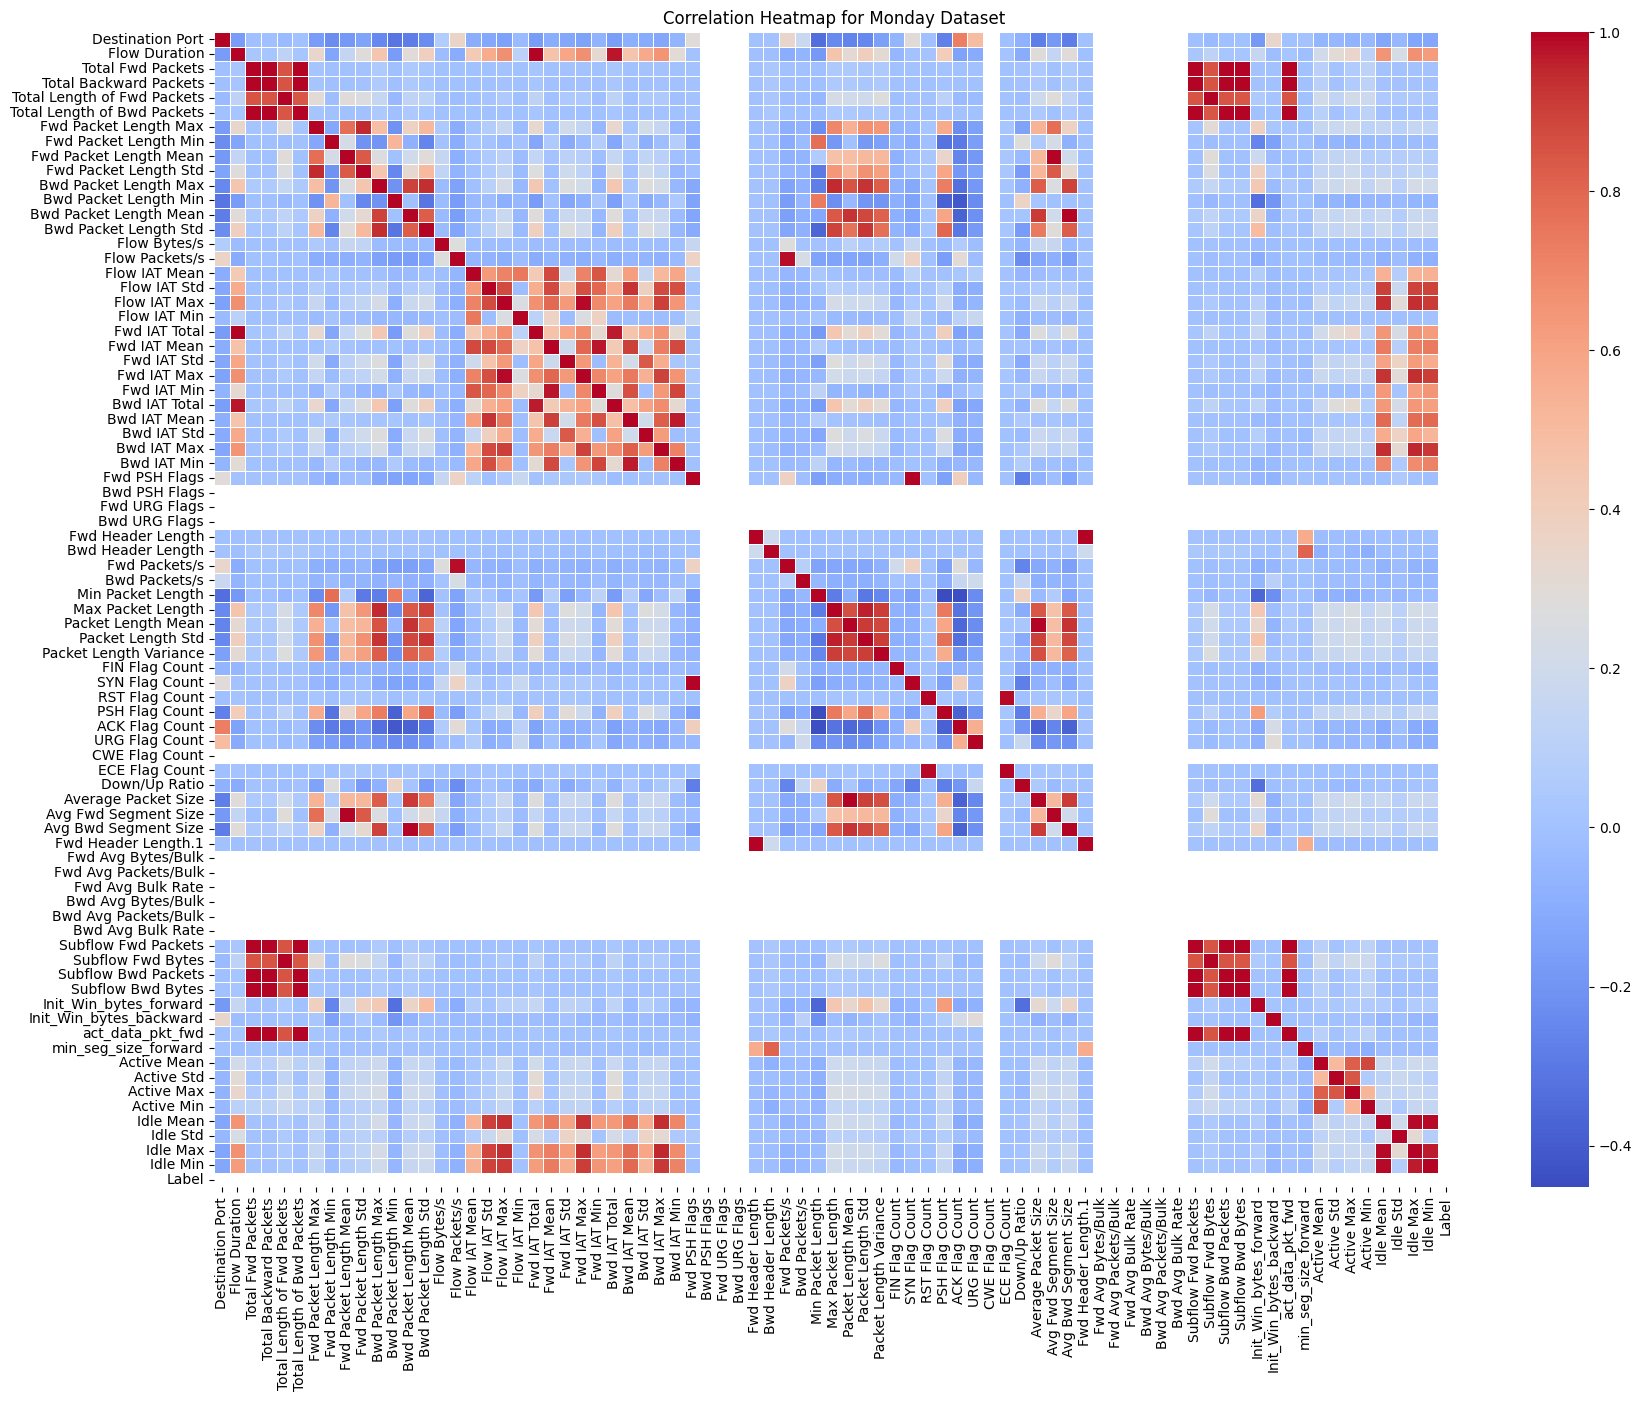

In [17]:
corr_matrix = monday_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Correlation Heatmap for Monday Dataset')
plt.show()

In [16]:
# Remove the identified highly correlated features
reduced_monday_data = monday_data.drop(columns=list(correlated_features))

# Review the shape of the data after removal to confirm the changes
print("Shape of the dataset after removing highly correlated features:", reduced_monday_data.shape)

Shape of the dataset after removing highly correlated features: (529918, 49)


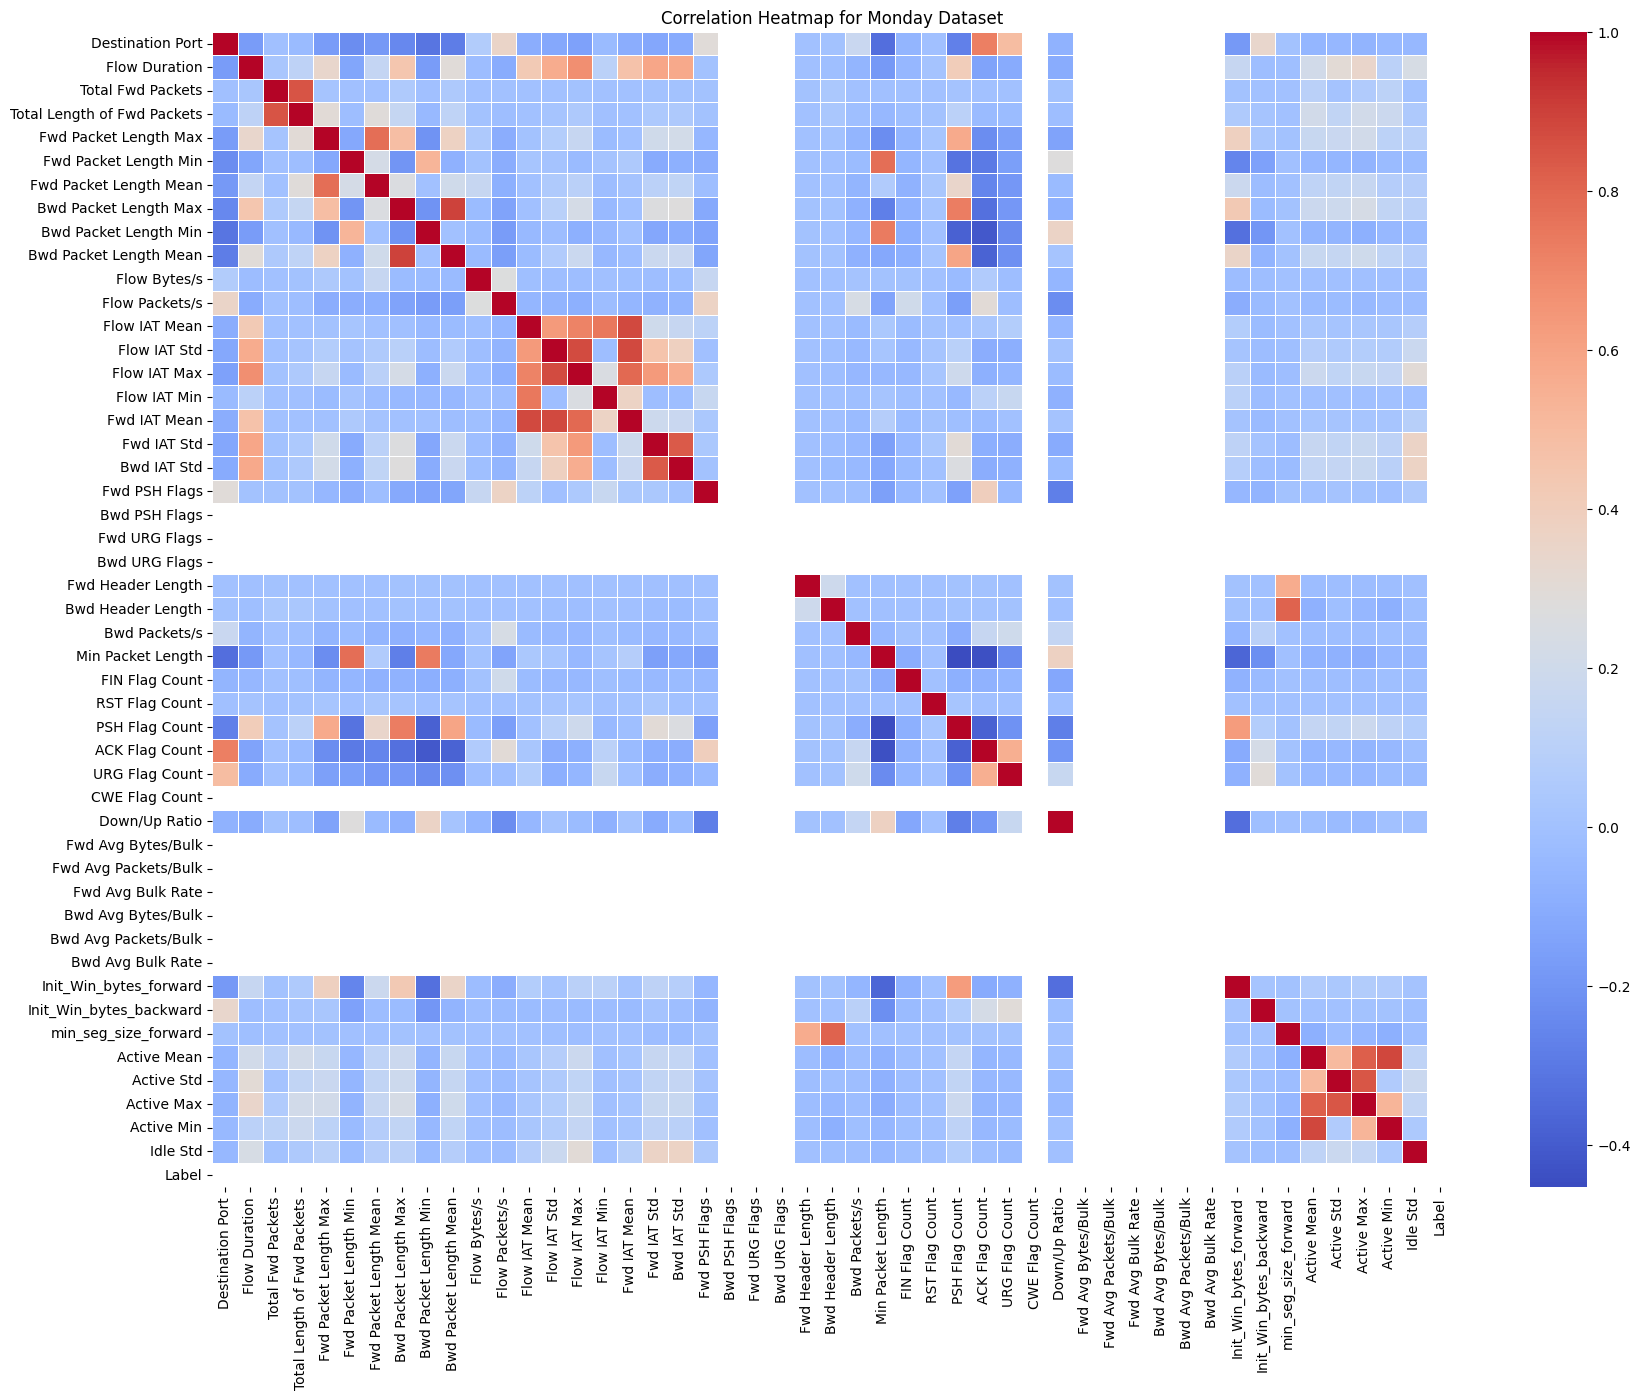

In [18]:
reduced_corr_matrix = reduced_monday_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(reduced_corr_matrix, cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Correlation Heatmap for Monday Dataset')
plt.show()

In [7]:
# Iterating over dataset files
from pathlib import Path


for path in dataset_paths:
    print(f"\nLoading data from {Path(path).name}")
    data = pd.read_csv(path)
    
    # Iterating over each column in the dataset
    for column in data.columns:
        unique_values = data[column].unique()
        # Limiting the number of unique values displayed for brevity
        if len(unique_values) > 20:
            print(f"{column}: {len(unique_values)} unique values, example: {unique_values[:20]}")
        else:
            print(f"{column}: {unique_values}")

    print("\n" + "="*50 + "\n")  # Separator between files


Loading data from Monday-WorkingHours.pcap_ISCX.csv
 Destination Port: 30238 unique values, example: [49188 49486    88  1034   389  1045  1051    80 49671  1029  1059   139
   135 49666  3268     0 49478 49480 49488   123]
 Flow Duration: 225076 unique values, example: [    4     1     3   609   879  1160   524     6  1119 18378   822   876
  1009   616     5   946   927   973   953   740]
 Total Fwd Packets: 662 unique values, example: [  2   7   9   1  13   8   3  21  15  23  10  19  11  17  22  39 231   5
   6 267]
 Total Backward Packets: 844 unique values, example: [  0   4   6   1  13  11   7  14   2  10  20  12  34   5   8  53   3 101
  30   9]
Total Length of Fwd Packets: 9511 unique values, example: [  12  484  656 3134 2812    6 3160 4160  458  630 2748  654 3112 2814
 4948 4122  103 3720 3084 4094]
 Total Length of Bwd Packets: 25014 unique values, example: [   0  414 3064 3048 2820    6 3060 5724  356 2942 2780 3012 2836  270
 1038 3054  191 2672   12 2984]
 Fwd Packet Le

In [26]:
for i, col in enumerate(reduced_monday_data):
    print(reduced_monday_data.columns[i], reduced_monday_data[col].unique())

Destination Port [49188 49486    88 ... 36236 40299 60922]
Flow Duration [     4      1      3 ... 202745 256303  18738]
Total Fwd Packets [     2      7      9      1     13      8      3     21     15     23
     10     19     11     17     22     39    231      5      6    267
     52     88     26    291     58    106     14    156     33    105
    414    300    124      4     49     66    126     12     18     96
     20     31     35     28     16     24    264    185    120     36
     25   1186     60     46     37   1011    148     69   1167    240
     43    123    250    165     42    734     27    208    413     71
    122    336     50     55    101    177    102    129    190     63
    211    246     44     29     38   1266     30     48     32    135
     78    256    138    386    415    764     93     34    171     41
     73     74     87     61     59    252    110    114    390    182
     40     67    128     56    103    224    307    149     45     80
    154  